# ProGAN(Progressive Growing of GANs for Improved Quality, Stability, and Variation
* ProGAN 실습

In [25]:
import tensorflow as tf
import tensorflow.keras as K
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
import time
import imageio
from IPython import display
from skimage import transform

In [2]:
# ProGAN의 특징
# 1. 점진적 증대(Progressive Growing & Smoothing in of Higher Resolution Layers)

def upscale_layer(layer, upscale_factor):
  '''
  upscale_factor(int) 만큼 층(텐서)을 업스케일
  텐서 크기는 [group, height, width, channels]
  '''

  height, width = layer.get_shape()[1:3]
  size = (upscale_factor * height, upscale_factor * width)
  upscaled_layer = tf.image.resize_nearest_neighbor(layer, size)
  
  return upscaled_layer

def smoothly_merge_last_layer(list_of_layers, alpha):
  '''
  임곗값 알파를 기반으로 층을 부드럽게 합침
  이 함수는 모든 층이 이미 RGB로 바뀌었다고 가정
  Generator를 위한 함수
  
  : list_of_layers : 해상도(크기) 순서대로 정렬된 텐서 리스트
  : alpha : (0, 1) 사이 크기의 실수
  '''

  last_fully_trained_layer = list_of_layers[-2]  # upscaling을 위해 끝에서 2번째 층을 선택
  last_layer_upscaled = upscale_layer(last_fully_trained_layer, 2)   # 끝에서 2번째 층을 upscale_layer함수로 upscaling

  larger_native_layer = list_of_layers[-1]       # 새로 추가된 층은 아직 완전히 훈련되지 않은 상태

  assert larger_native_layer.get_shape() == last_layer_upscaled.get_shape()   # 합치기 전에 층 크기가 같은지 확인

  new_layer = (1-alpha) * last_layer_upscaled + larger_native_layer * alpha    # 곱셈은 broadcasting되어 수행됨!

  return new_layer

In [3]:
# 2. 미니배치 표준편차(Mini-Batch Standard Deviation)
# [4D->3D]높이,너비,컬러 채널에 대해 배치에 있는 모든 이미지의 표준편차를 계산함. 이렇게 하면 각 픽셀과 채널에 대한 표준편차로 채워진 하나의 이미지를 얻음
# [3D->2D]모든 채널에 대해 표준편차를 평균하여 하나의 특성맵 또는 픽셀에 대한 표준편차 행렬을 얻음. 하지만 컬러 채널은 하나로 합쳐짐

def minibatch_std_layer(layer, group_size=4):
  '''
  층의 minibatch 표준편차를 계산함
  층의 Data Type은 float32로 가정(그렇지 않다면 데이터형 변환이 필요함!)
  '''

  group_size = K.backend.minimum(group_size, tf.shape(layer)[0]) # mini_batch는 group_size로 나눌 수 있거나 group_size보다 같거나 작아야 함
  shape = list(K.int_shape(input))
  shape[0] = tf.shape(input)[0]
  minibatch = K.backend.reshape(layer, 
                                (group_size, -1, shape[1], shape[2], shape[3])   # minibatch 수준에서 연산하기 위해 크기를 바꿈. 층이 [그룹(G), 미니배치(M), 너비(W), 높이(H), 채널(C)] 라고 가정함
                                ) 
  
  minibatch -= tf.reduce_mean(minibatch, axis=0, keepdims=True)   # (M, W, H, C) 그룹의 평균을 계산
  minibatch = tf.reduce_mean(K.backend.square(minibatch), axis=0) # (M, W, H, C) 그룹의 분산을 계산
  minibatch = K.backend.square(minibatch + 1e-8)                  # (M, W, H, C) 그룹의 표준편차를 계산
  minibatch = tf.reduce_mean(minibatch, axis=[1,2,3], keepdims=True)   # 특성 맵을 평균하여 [M, 1, 1, 1] 픽셀을 얻습니다

  minibatch = K.backend.title(minibatch, [group_size, 1, shape[2], shape[3]]  # 스칼라 값을 그룹과 픽셀에 맞게 변환
                              )
  
  return K.backend.concatenate([layer, minibatch], axis=1)    # 새로운 특성맵이 추가됨!

In [4]:
# 3. 균등 학습률(Equalized Learning_rate)

def equalize_lr(shape, gain, fain_in=None):
  '''
  He 초기화의 상수로 모든 층의 가중치를 조정하여
  특성마다 각기 다른 Dynamic Range를 가지도록 분산을 맞춰줌
  shape : 텐서 층의 크기 --> 각 층의 차원
  gain : 일반적으로 sqrt(2)
  fan_in : 세이비어 / He 초기화에서 입력 연결 개수
  '''

  if fan_in is None: fan_in = np.prod(shape[:-1])
  std = gain / K.sqrt(fan_in)
  wscale = K.constant(std, name='wscale', dtype=np.float32)
  adjusted_weights = K.get_value('layer', shape=shape,
                                 initializer=tf.initializers.random_normal()) * wscale

  return adjusted_weights                                

In [5]:
# 4. 픽셀 정규화

def pixelwise_feat_norm(inputs, **kwargs):
  '''
  inputs : Keras의 TF 층
  '''
  normalization_constant = K.backend.sqrt(
                                          K.backend.mean(inputs ** 2, axis=-1, keepdims=True) + 1.0e-8
                                          )
  return inputs / normalization_constant

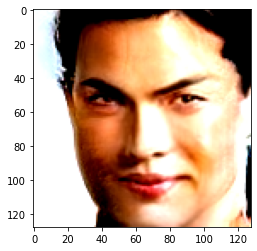

In [33]:
# Tensorflow Hub 기능으로 ProGAN 모델 로드


module = hub.KerasLayer('https://tfhub.dev/google/progan-128/1')   # ProGAN import

latent_dim = 512  # 생성할 공간의 잠재 차원

latent_vector = tf.random.normal([1, latent_dim], seed=1337)  # seed를 변경시 다른 얼굴을 생성함

interpolated_images = module(latent_vector)  # 잠재공간에서 이미지 생성

plt.imshow(interpolated_images.numpy().reshape(128,128,3))
plt.show()